In [43]:
import os
import torch
import numpy as np
import albumentations as A
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
from pathlib import Path
from PIL import Image
from torch import nn

# Load models

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        # overwrite MLP / decoder da EfficientNet B0
        self.backbone._fc = nn.Sequential(
            nn.Linear(1280, 2),
        )
    
    def forward(self, x):
        return self.backbone(x)

In [45]:
def load_and_preprocess(image_path: str) -> torch.Tensor:
    """
    Loads image from filepath to a numpy ndarray.
    Then takes ndarray and apply transforms (padding, resizing, normalization) and transforms to tensor

    NOTE: numpy images (from PIL) are channel-last (form (H, W, 3) in case of RGB / 3 channels)

    outputs a channel-last torch (3, 224, 224) tensor, already normalized to mean=[0.5,0.5,0.5] and std=[0.5,0.5,0.5]
    """
    TARGET_H = 224
    TARGET_W = 224
    MEAN = [0.5, 0.5, 0.5]
    STD = [0.5, 0.5, 0.5]

    numpy_img = np.asarray(Image.open(image_path).convert("RGB"))

    h, w = numpy_img.shape[0], numpy_img.shape[1]
    zero_padding_to_square = A.PadIfNeeded(min_height=max(h, w), min_width=max(h, w), border_mode=cv2.BORDER_CONSTANT, value=0)
    resize = A.Resize(height=TARGET_H, width=TARGET_W, always_apply=True)
    normalize = A.Normalize(mean=MEAN, std=STD, always_apply=True)
    to_tensor = ToTensorV2(always_apply=True)

    pipeline = A.Compose([zero_padding_to_square, resize, normalize, to_tensor])
    # NOTE albumentations transforms must receive the image as
    # a keyword argument called image
    # or we get "KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'"
    return pipeline(image=numpy_img)["image"]


In [46]:
TEST_DIR = "../data/test_raw"
MODELS_DIR = "../best_model"
CLASS_NAMES = os.listdir(TEST_DIR)

models_per_class = {}
for cls in CLASS_NAMES:
    for model_name in os.listdir(MODELS_DIR):
        if model_name.startswith(cls):
            model = Net()    
            load_path = Path(MODELS_DIR) / model_name
            model.load_state_dict(torch.load(load_path)["state_dict"])
            models_per_class[cls] = model

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


# 2. DataLoader

In [47]:
def get_class(image_path: Path):
    # 0-th is the '..'
    # 1-th and 2dn is the TEST_DIR (data/test_raw)
    return image_path.parts[3]

table = []
for cwd, _, files in os.walk(TEST_DIR):
    for f in files:
        row = [f"{cwd}/{f}", get_class(Path(cwd) / f)]
        for cls in CLASS_NAMES:
            model = models_per_class[cls]
            model.eval()
            img = load_and_preprocess(Path(cwd) / f)
            logit = model(img.unsqueeze(dim=0)).squeeze(dim=0)
            score = torch.softmax(logit, dim=0)[0].item()
            row.append(score)
        table.append(row)

df = pd.DataFrame(table, columns=["Path", "True Class", *[cls + " score" for cls in CLASS_NAMES]])

In [48]:
df

,Path,True Class,Sclerosis score,Normal score,Podocytopathy score,Membranous score,Hypercellularity score,Crescent score
0,../data/test_raw/Sclerosis/segmental sclerosis...,Sclerosis,0.662451,0.000013,0.037473,0.000534,0.284575,0.014055
1,../data/test_raw/Sclerosis/segmental sclerosis...,Sclerosis,0.031844,0.016017,0.997996,0.098214,0.001646,0.028116
2,../data/test_raw/Sclerosis/segmental sclerosis...,Sclerosis,0.993598,0.000032,0.004900,0.001267,0.264873,0.017494
3,../data/test_raw/Sclerosis/segmental sclerosis...,Sclerosis,0.997101,0.000489,0.039223,0.005345,0.026325,0.000162
4,../data/test_raw/Sclerosis/segmental sclerosis...,Sclerosis,0.686899,0.001195,0.341619,0.001189,0.215078,0.013908
...,...,...,...,...,...,...,...,...
66,../data/test_raw/Crescent/glomerular crescet/c...,Crescent,0.000021,0.000010,0.002395,0.000036,0.010399,0.997575
67,../data/test_raw/Crescent/glomerular crescet/k...,Crescent,0.000002,0.000381,0.001923,0.001939,0.029744,0.972979
68,../data/test_raw/Crescent/glomerular crescet/u...,Crescent,0.000115,0.000633,0.000293,0.000117,0.107040,0.990093
69,../data/test_raw/Crescent/glomerular crescet/R...,Crescent,0.001670,0.000219,0.012137,0.000063,0.005180,0.992986


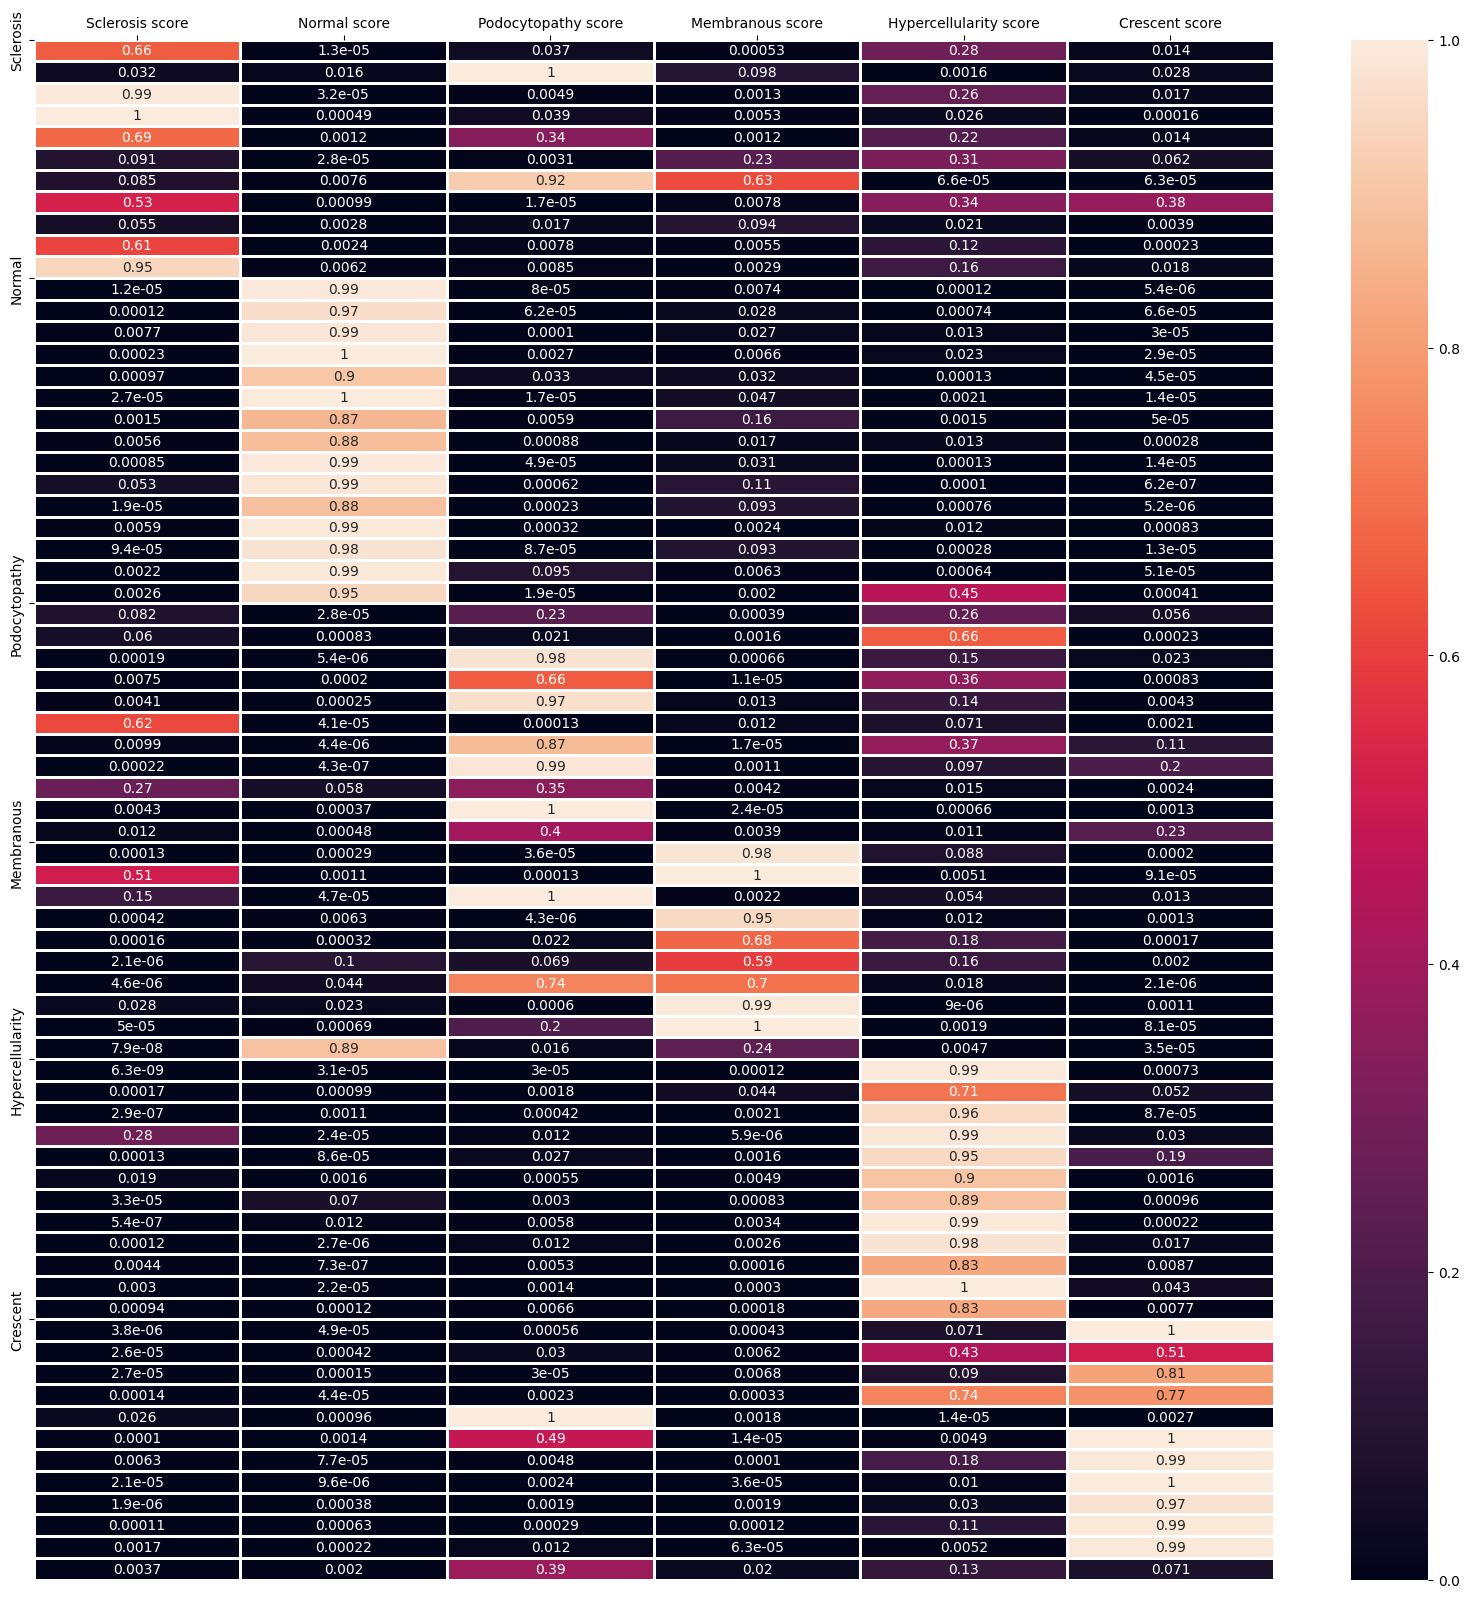

In [51]:
from itertools import accumulate

ticks_pos = [0] + [len(df[df["True Class"] == cls]) for cls in CLASS_NAMES]
# 0, len(c1), len(c1) + len(c2), ... are the indices of ticks for class 1, 2, 3, ...
ticks_pos = list(accumulate(ticks_pos))[:-1]


plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(
    df[[cls + " score" for cls in CLASS_NAMES]],
    linewidth=1,
    vmin=0.0,
    vmax=1.0,
    annot=True
)
heatmap.xaxis.tick_top()
heatmap.yaxis.set_ticks(ticks_pos)
heatmap.yaxis.set_ticklabels(CLASS_NAMES)
plt.show()